In [1]:
import sys, os, itertools, re, gc, copy
import h5py
from pathlib import Path
from collections import Iterable, OrderedDict, defaultdict, Counter
import pandas as pd
from util import print_datetime, openH5File, parseIiter, a2i

import numpy as np
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import umap

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("white")
plt.rcParams['font.size'] = 16
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline
%config InlineBackend.figure_format='retina'

from loadData import loadExpression, loadDataset
from Model import Model
from Result import Result, plotConvergenceQ, findBest

/work/magroup/tianming/anaconda3/envs/SpiceMix-ma2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  after removing the cwd from sys.path.


## Find the best random seed
We recommend to run SpiceMix using 5 or more different random seeds (via argument `--random_seed4kmeans`) for each hyperparameter configuration and pick the run with the best random seed for downstream analysis.

In the following code block, we search the file system and collect the h5 files of different random seeds. And then we plot the increament of the Q-value against the iteration number, in order to check whether these runs have converged. It is normal if the Q-value decreases, indicated by negative increaments, because of the utilization of the mean-field assumption in our optimization process. Typically, 200 iterations are adequate for SpiceMix on tested real datasets, including STARmap and seqFISH.

Found 500 iterations from SpiceMix_nFOVs4_K10_rs0_1e-4.h5
Found 500 iterations from SpiceMix_nFOVs4_K10_rs1_1e-4.h5
Found 500 iterations from SpiceMix_nFOVs4_K10_rs2_1e-4.h5
Found 500 iterations from SpiceMix_nFOVs4_K10_rs3_1e-4.h5
Found 500 iterations from SpiceMix_nFOVs4_K10_rs4_1e-4.h5
Found 100 iterations from NMF_nFOVs4_K10_rs0_NMF.h5
Found 100 iterations from NMF_nFOVs4_K10_rs1_NMF.h5
Found 100 iterations from NMF_nFOVs4_K10_rs2_NMF.h5
Found 100 iterations from NMF_nFOVs4_K10_rs3_NMF.h5
Found 100 iterations from NMF_nFOVs4_K10_rs4_NMF.h5


(0.001, 1565.4802505864193)

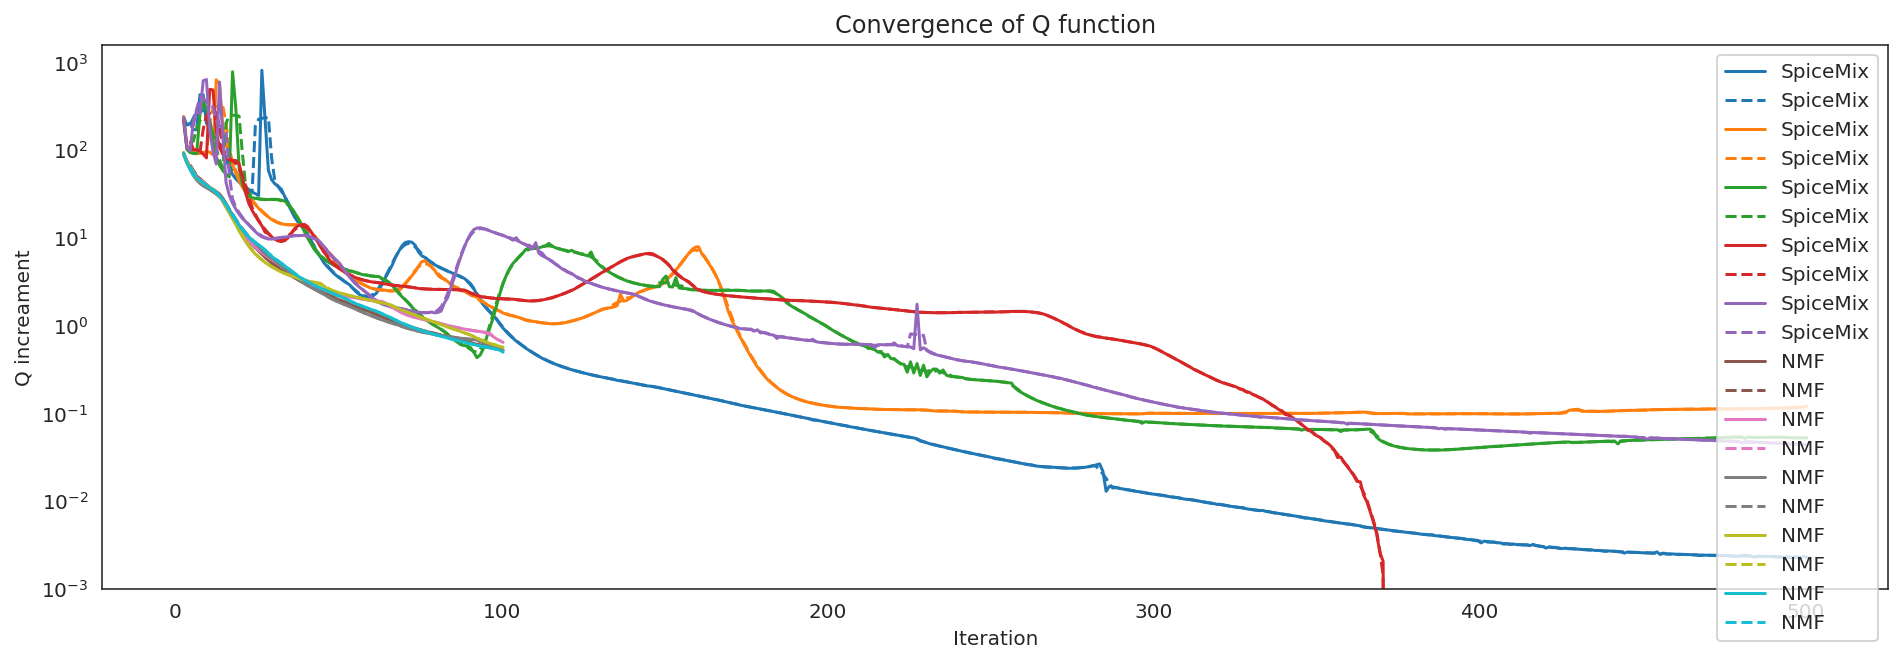

In [2]:
path2dataset = Path('..') / 'data' / 'synthetic_cortex'
results_list_SpiceMix = [
    f
    for f in sorted(os.listdir(path2dataset / 'results'))
    if re.match('SpiceMix_nFOVs4_K10_rs(\d+)_1e-4.h5', f)
]

results_list_NMF = [
    f
    for f in sorted(os.listdir(path2dataset / 'results'))
    if re.match('NMF_nFOVs4_K10_rs(\d+)_NMF.h5', f)
]

colors = itertools.cycle(f'C{_}' for _ in range(10))
fig, ax = plt.subplots(figsize=(16, 5))
for r in results_list_SpiceMix: plotConvergenceQ(ax, path2dataset, r, c=next(colors), label='SpiceMix')
for r in results_list_NMF:      plotConvergenceQ(ax, path2dataset, r, c=next(colors), label='NMF')
ax.legend()
ax.set_title('Convergence of Q function')
ax.set_xlabel('Iteration')
ax.set_ylabel('Q increament')
ax.set_yscale('log')
ax.set_ylim(max(1e-3, ax.get_ylim()[0]), ax.get_ylim()[1])

Now we decide the best random seed by finding the run with the highest Q-value after iteration `iiter` (defaults to the last iteration (-1)).

We suggest not to determine the optimal hyperparameter configuration based on the Q-value.

In [3]:
result_filename_best_SpiceMix = findBest(path2dataset, results_list_SpiceMix, iiter=-1)
result_filename_best_NMF      = findBest(path2dataset, results_list_NMF     , iiter=-1)

Using iteration 500 from SpiceMix_nFOVs4_K10_rs0_1e-4.h5
Using iteration 500 from SpiceMix_nFOVs4_K10_rs1_1e-4.h5
Using iteration 500 from SpiceMix_nFOVs4_K10_rs2_1e-4.h5
Using iteration 500 from SpiceMix_nFOVs4_K10_rs3_1e-4.h5
Using iteration 500 from SpiceMix_nFOVs4_K10_rs4_1e-4.h5
The best one is model #0 - result filename = SpiceMix_nFOVs4_K10_rs0_1e-4.h5
Using iteration 100 from NMF_nFOVs4_K10_rs0_NMF.h5
Using iteration 100 from NMF_nFOVs4_K10_rs1_NMF.h5
Using iteration 100 from NMF_nFOVs4_K10_rs2_NMF.h5
Using iteration 100 from NMF_nFOVs4_K10_rs3_NMF.h5
Using iteration 100 from NMF_nFOVs4_K10_rs4_NMF.h5
The best one is model #4 - result filename = NMF_nFOVs4_K10_rs4_NMF.h5


## Load and annotate SpiceMix/NMF results
We create a `Result` object for each run that aims to store data for visualization.

In [4]:
obj_SpiceMix = Result(
    path2dataset=path2dataset,
    result_filename=result_filename_best_SpiceMix,
)
obj_NMF      = Result(
    path2dataset=path2dataset,
    result_filename=result_filename_best_NMF,
)

Result file = ../data/synthetic_cortex/results/SpiceMix_nFOVs4_K10_rs0_1e-4.h5


Result file = ../data/synthetic_cortex/results/NMF_nFOVs4_K10_rs4_NMF.h5


We plot the increament of the Q-value again just to double check.

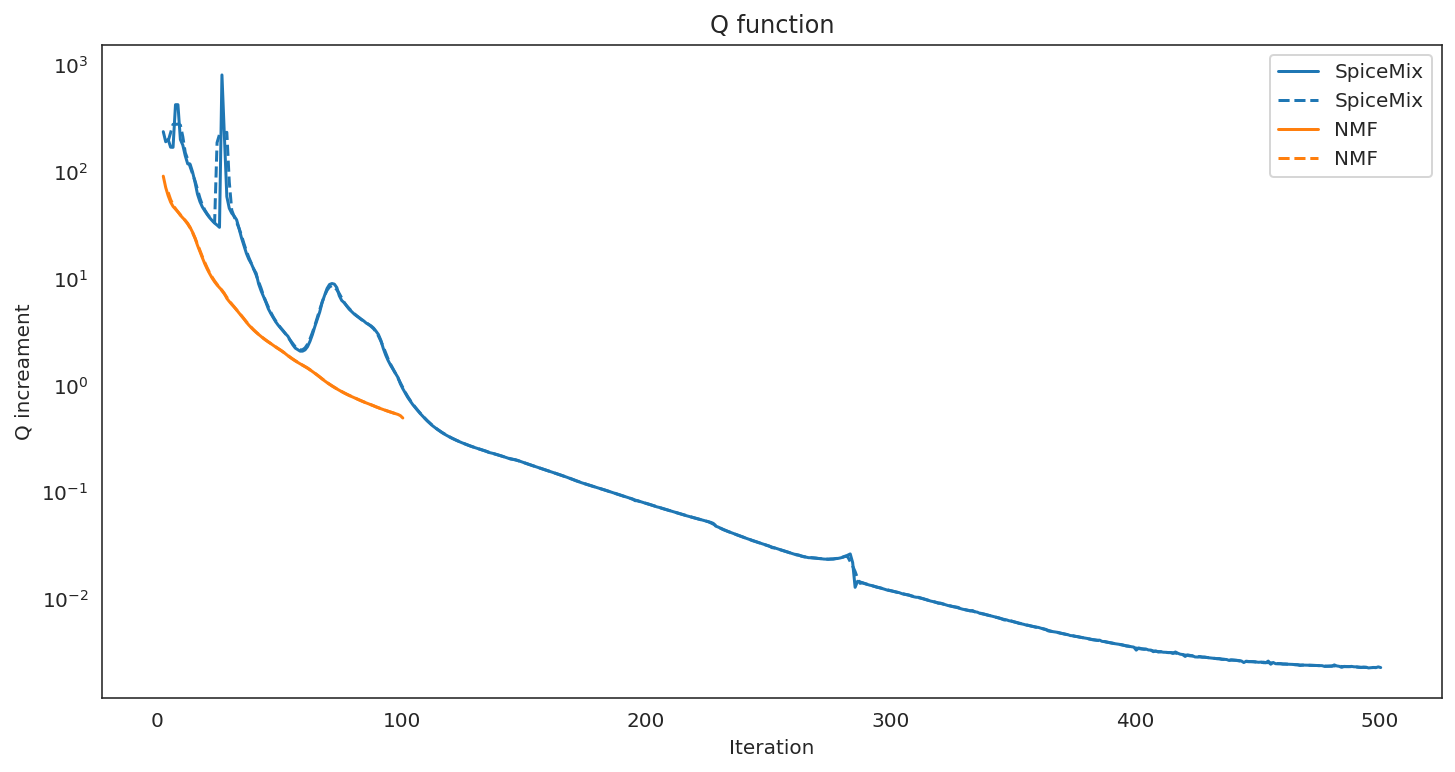

In [5]:
# Prior to downstream analysis, we should make sure the models have converged
fig, ax = plt.subplots(figsize=(12, 6))
obj_SpiceMix.plotConvergenceQ(ax, label='SpiceMix', c='C0')
obj_NMF     .plotConvergenceQ(ax, label='NMF'     , c='C1')
plt.title('Q function')
plt.xlabel('Iteration')
plt.ylabel('Q increament')
plt.yscale('log')
plt.legend()

We load latent states for all cells after the last iteration (`iiter=-1`) of SpiceMix/NMF. The latent states will be store in the `Result` objects for later use.

In [6]:
obj_SpiceMix.loadLatentStates(iiter=-1)
obj_NMF     .loadLatentStates(iiter=-1)

Iteration 500
Iteration 100


We do hierarchical clustering of all cells in the latent space. The optimal number of clusters is determined by the Calinski-Harabasz index.

K_opt = 8
#clusters = 8, #-1 = 0
K_opt = 5
#clusters = 5, #-1 = 0


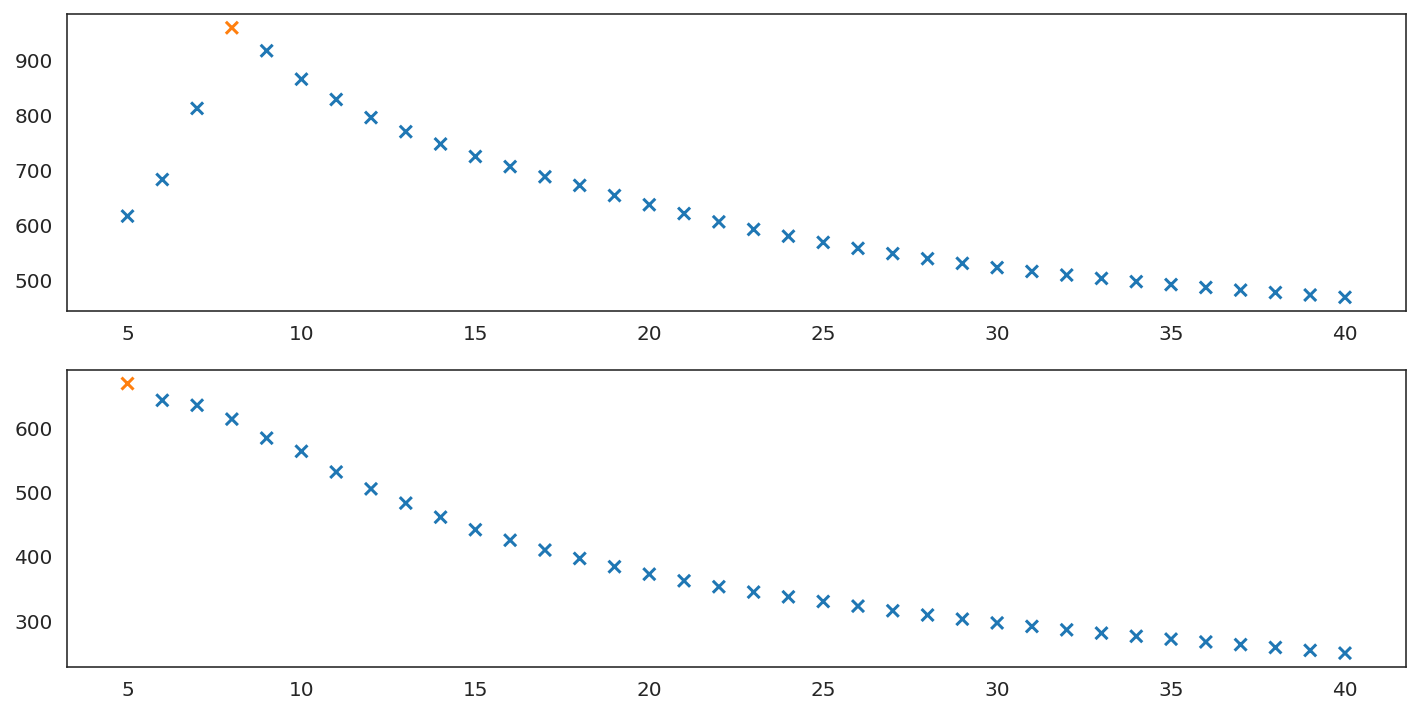

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
obj_SpiceMix.clustering(axes[0], K_range=np.arange(5, 41))
obj_NMF     .clustering(axes[1], K_range=np.arange(5, 41))

For better visualization, we can change the order of metagenes in plots
We may skip this code block if this is the first time to analyze these results

In [8]:
obj_SpiceMix.reorderMetagenes([1, 4, 9, 3, 0, 6, 2, 7, 5, 8])
obj_NMF     .reorderMetagenes([0, 6, 4, 9, 7, 8, 1, 5, 3, 2])

We annotate SpiceMix clusters, and assign a color to each of these clusters and the cell types loaded from `celltype_<FOV>.txt`. We may also change the order of SpiceMix clusters, cell types, and replicates.

In [9]:
# Assign a name (a str) to each raw cluster (a natural number starting from 0)
# To merge raw clusters, assign the same name to them
obj_SpiceMix.annotateClusters({
    3: 'eL1', 4: 'eL2', 5: 'eL3', 7: 'eL4', 0: 'Inh-1', 2: 'Inh-2', 6: 'Glial-1', 1: 'Glial-2',
})
obj_NMF.annotateClusters({
    2: 'eL1/2/3', 1: 'eL4', 0: 'Inh', 4: 'Glial-1', 3: 'Glial-2',
})

# Assign a custom color to each cluster
obj_SpiceMix.assignColors('cluster', {
    'NA': 'black',
    'eL1': 'lightskyblue', 'eL2': 'greenyellow', 'eL3': 'mediumspringgreen',
    'eL4': 'palegreen',
    'Inh-1': 'gold', 'Inh-2': 'firebrick',
    'Glial-1': 'gainsboro', 'Glial-2': 'palegoldenrod',
})
obj_NMF.assignColors('cluster', {
    'NA': 'black',
    'eL1': 'lightskyblue', 'eL2': 'greenyellow', 'eL3': 'mediumspringgreen',
    'eL4': 'palegreen',
    'eL1/2/3': 'lightskyblue',
    'Inh': 'gold',
    'Glial-1': 'gainsboro', 'Glial-2': 'palegoldenrod',
})
obj_SpiceMix.assignColors('cell type', {
    'eL1': 'lightskyblue', 'eL2': 'greenyellow', 'eL3': 'mediumspringgreen',
    'eL4': 'palegreen',
    'Inh-1': 'gold', 'Inh-2': 'firebrick',
    'Glial-1': 'gainsboro', 'Glial-2': 'palegoldenrod',
})
obj_NMF.assignColors('cell type', {
    'eL1': 'lightskyblue', 'eL2': 'greenyellow', 'eL3': 'mediumspringgreen',
    'eL4': 'palegreen',
    'Inh-1': 'gold', 'Inh-2': 'firebrick',
    'Glial-1': 'gainsboro', 'Glial-2': 'palegoldenrod',
})
# Assign a custom order to a particular label for visualization
obj_SpiceMix.assignOrder('cluster', [
    'eL1', 'eL2', 'eL3', 'eL4', 'Inh-1', 'Inh-2', 'Glial-1', 'Glial-2',
])
obj_NMF.assignOrder('cluster', [
    'eL1/2/3', 'eL4', 'Inh', 'Glial-1', 'Glial-2',
])
obj_SpiceMix.assignOrder('cell type', [
    'eL1', 'eL2', 'eL3', 'eL4', 'Inh-1', 'Inh-2', 'Glial-1', 'Glial-2',
])
obj_NMF.assignOrder('cell type', [
    'eL1', 'eL2', 'eL3', 'eL4', 'Inh-1', 'Inh-2', 'Glial-1', 'Glial-2',
])
# May also assign an order to replicates
obj_SpiceMix.assignOrder('repli', ['0', '1', '2', '3'])
obj_NMF     .assignOrder('repli', ['0', '1', '2', '3'])

In [10]:
# do dimension reduction by UMAP
kwargs=dict(
    n_components=2,
    n_neighbors=10,
    min_dist=0.2,
    random_state=11234566,
)
obj_SpiceMix.UMAP(**kwargs)
obj_NMF     .UMAP(**kwargs)
# This is a wrapper of UMAP.umap
# Results are stored in columns 'UMAP 1', 'UMAP 2', and so on

## Visualizing the SpiceMix results in the UMAP space

We first inspect these clusters using UMAP. We visualize cells in the latent space colored by
- SpiceMix/NMF clusters (cluster)
- cell types from the original analysis (cell type)
- replicates (repli)

In this example, cells from different cell types are clearly separated by SpiceMix in the latent space. However, NMF failed to delineate eL1, eL2, and eL3 from each other. Besides, the boundary between the two inhibitory subtypes (Inh-1 (yellow) and Inh-2 (brown)) are not strong enough to separate the them.

Text(0.5, 1.0, 'Replicates')

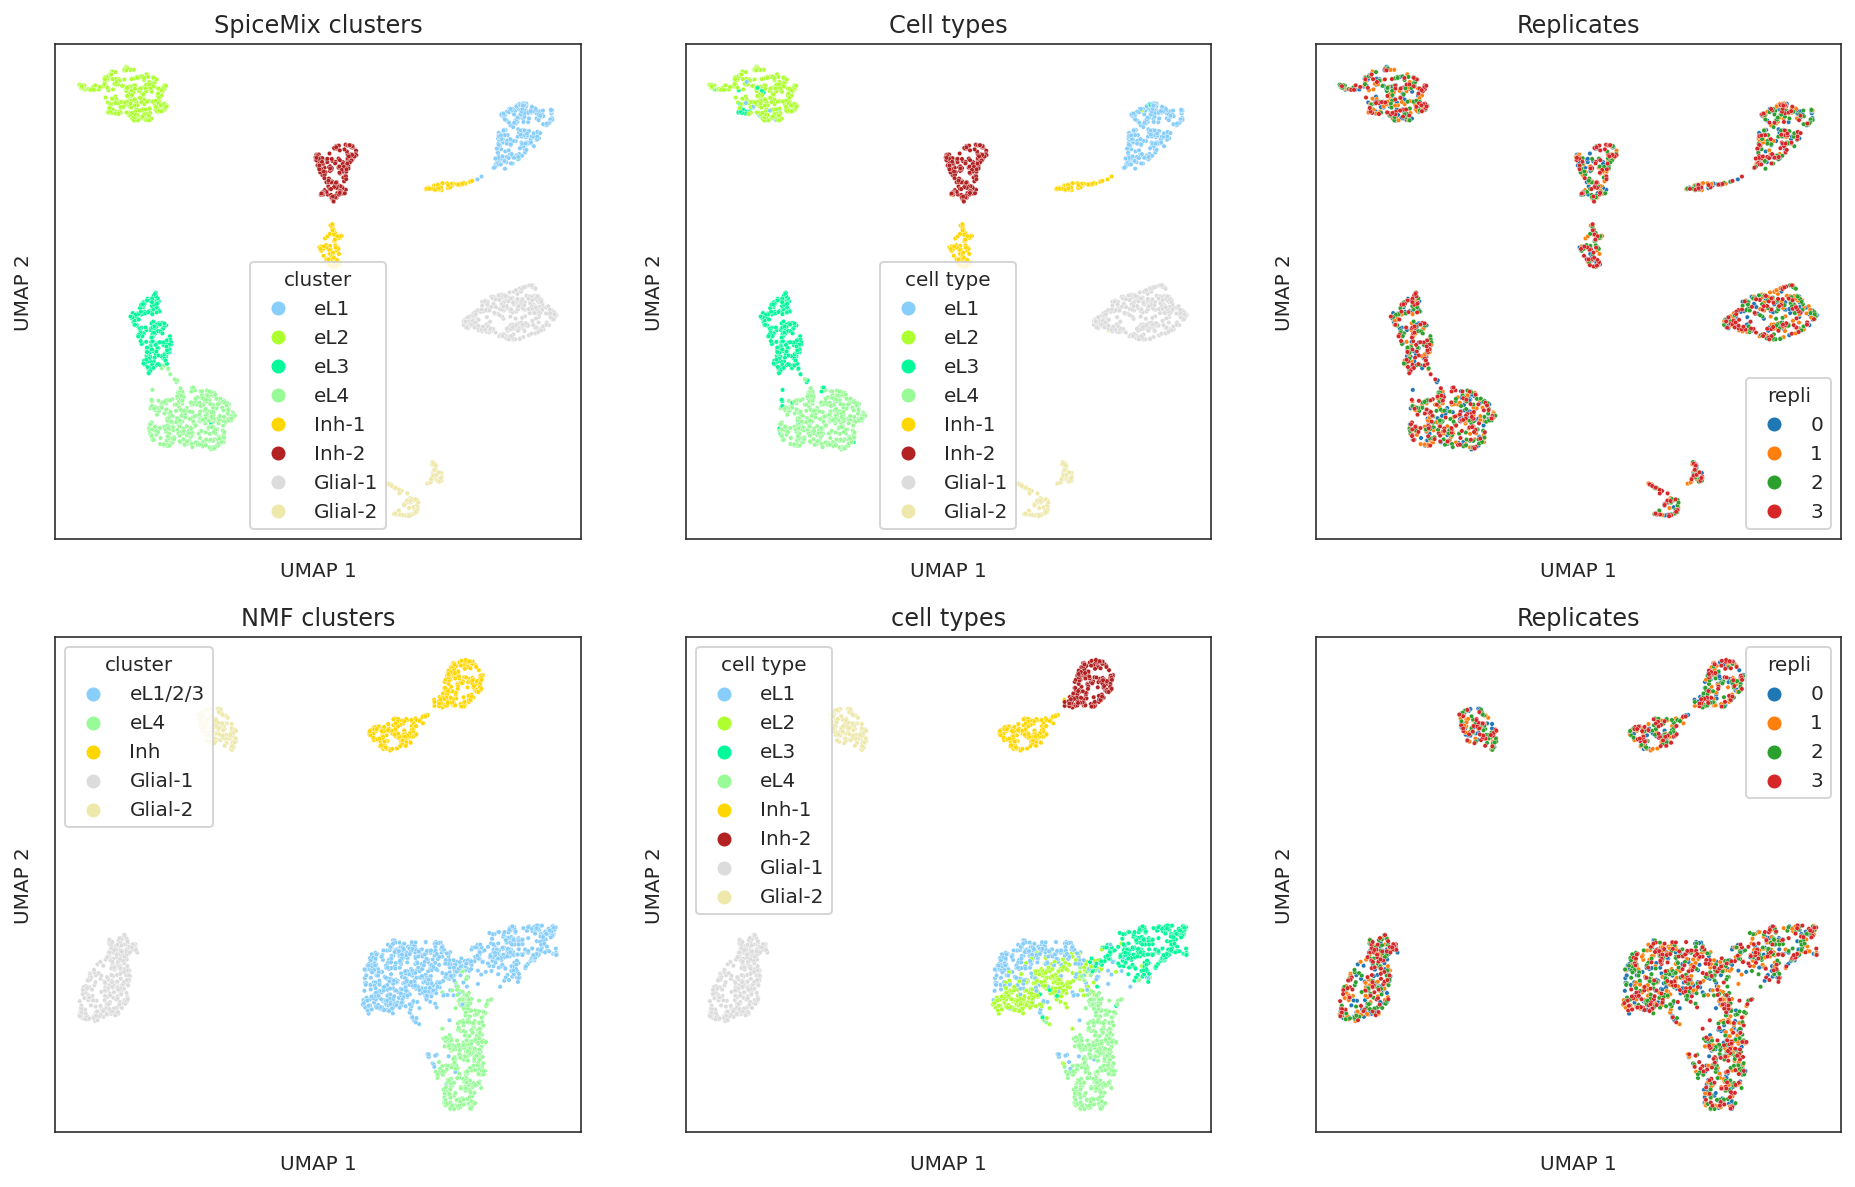

In [11]:
kwargs = dict(s=5)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
obj_SpiceMix.visualizeFeatureSpace(axes[0, 0], 'cluster'  , key_x='UMAP 1', key_y='UMAP 2', **kwargs)
obj_SpiceMix.visualizeFeatureSpace(axes[0, 1], 'cell type', key_x='UMAP 1', key_y='UMAP 2', **kwargs)
obj_SpiceMix.visualizeFeatureSpace(axes[0, 2], 'repli'    , key_x='UMAP 1', key_y='UMAP 2', **kwargs)
obj_NMF.visualizeFeaturesSpace(
    axes[1], ['cluster', 'cell type', 'repli'],
    key_x='UMAP 1', key_y='UMAP 2', **kwargs,
)
axes[0, 0].set_title('SpiceMix clusters')
axes[0, 1].set_title('Cell types')
axes[0, 2].set_title('Replicates')
axes[1, 0].set_title('NMF clusters')
axes[1, 1].set_title('cell types')
axes[1, 2].set_title('Replicates')

## In situ plots
We can overlay various features in the spatial space using functions `Result.visualizeFeaturesSpace` and `Result.visualizeFeaturesSpaces`. The latter is a wrapper of the former.

We visualize the spatial pattern of metagenes by overlaying the expression of metagenes in the spatial space.
SpiceMix metagenes are expected to show clearer spatial patterns, including but not limited to layer-like (ex. metagenes 1\~4) and scattered patterns (ex. metagenes 5 and 9) with less background expressions.

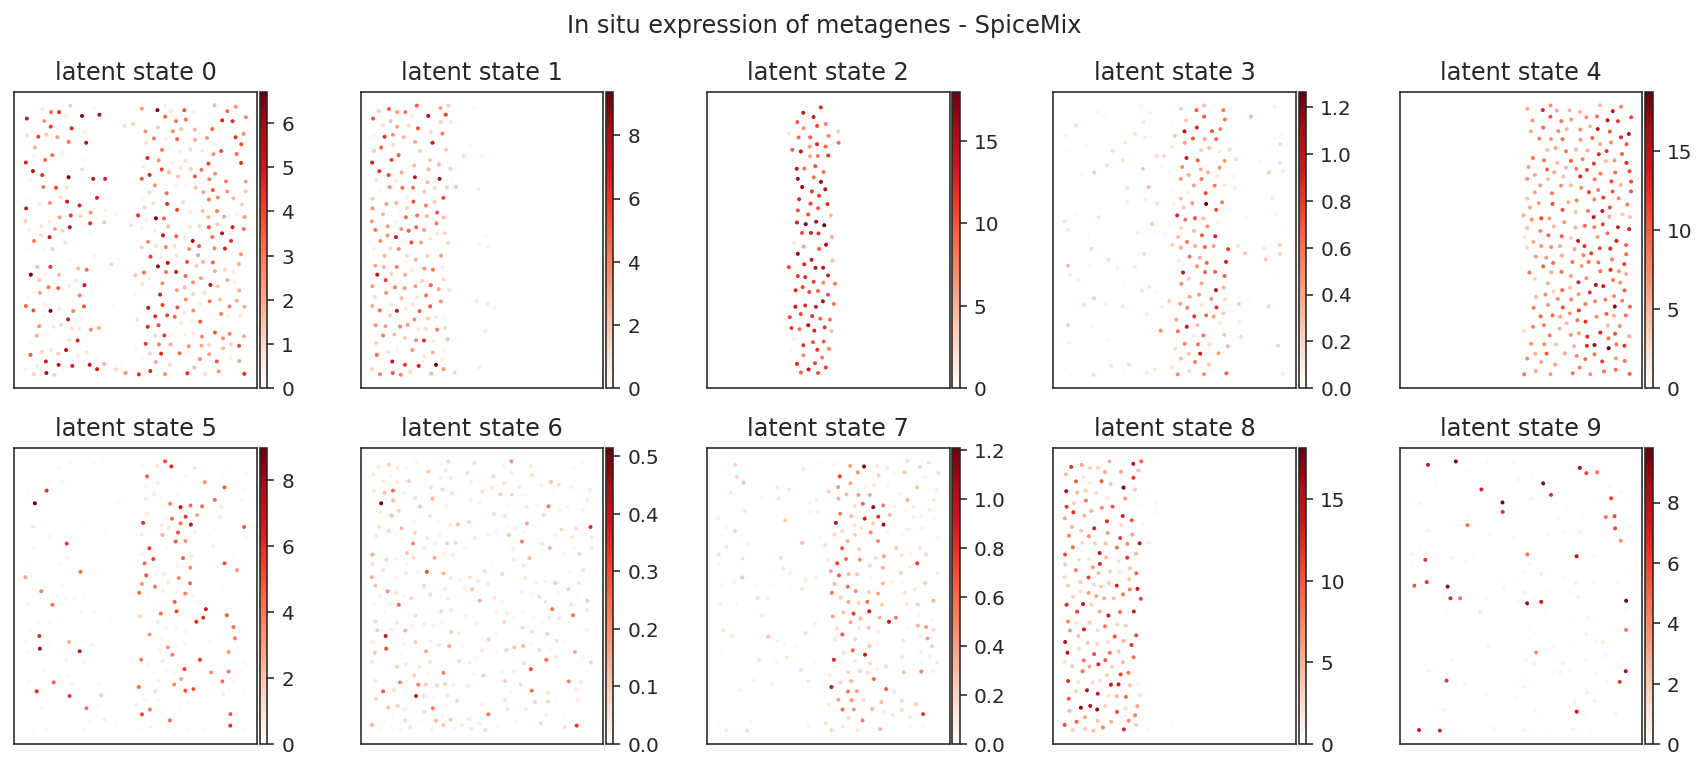

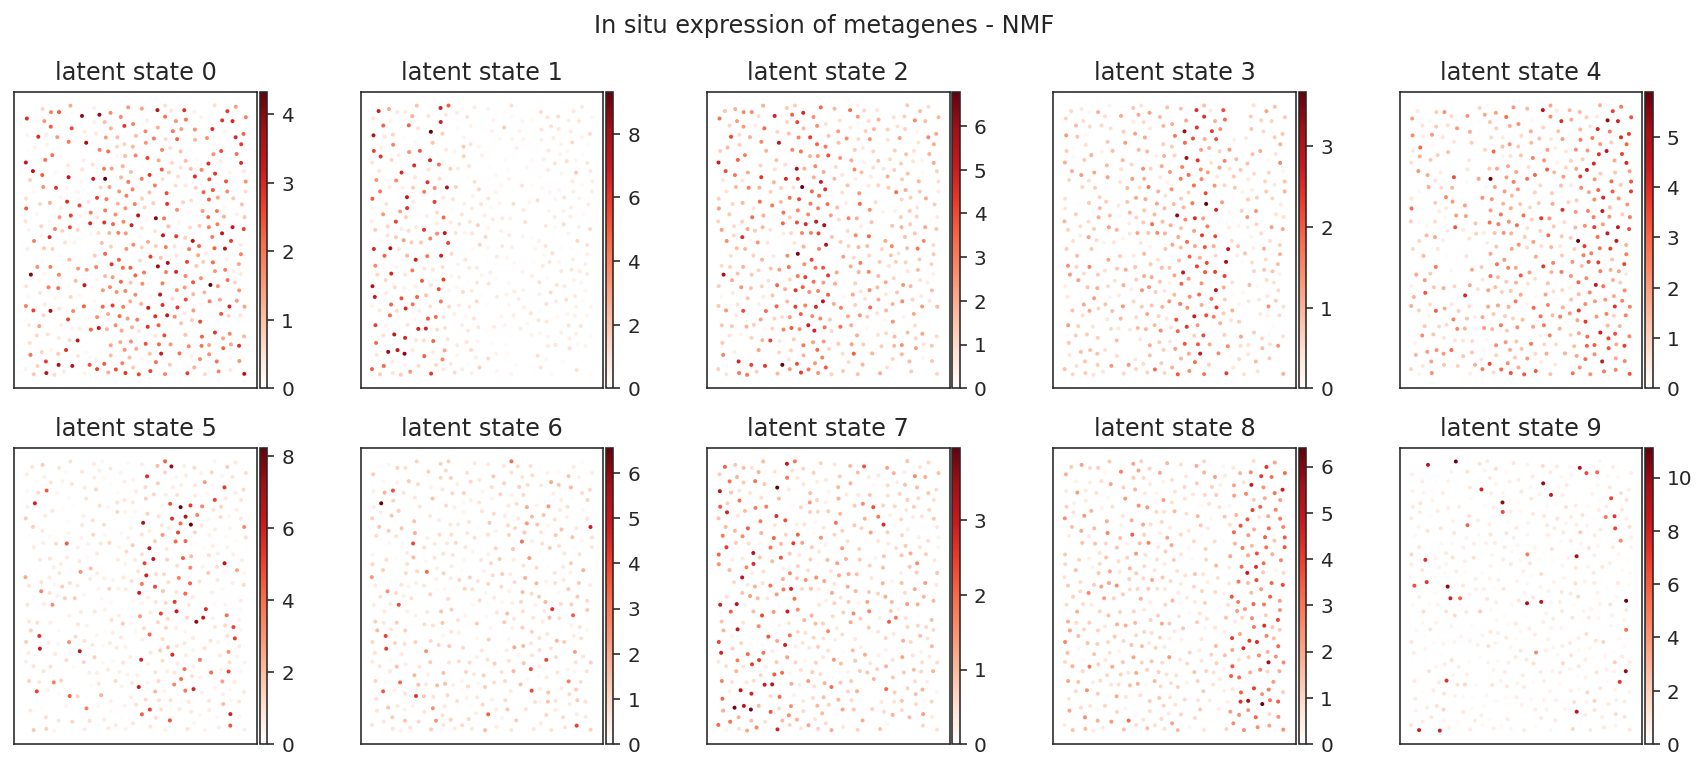

In [12]:
segmentdata = copy.deepcopy(plt.get_cmap('Reds')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    s=1, # change dot size here
    cmap=cm,
    repli='0', # we only show the first replicate in this code block
)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('In situ expression of metagenes - SpiceMix', y=.97)
obj_SpiceMix.visualizeFeaturesSpace(axes, **kwargs)
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('In situ expression of metagenes - NMF', y=.97)
obj_NMF     .visualizeFeaturesSpace(axes, **kwargs)
plt.show()

Using the same functions, we can overlay cell types and SpiceMix/NMF clusters on the spatial space.
Similarly, SpiceMix is able to capture clusters that exhibit any kind of spatial pattern.

Text(0.5, 1.0, 'NMF clusters')

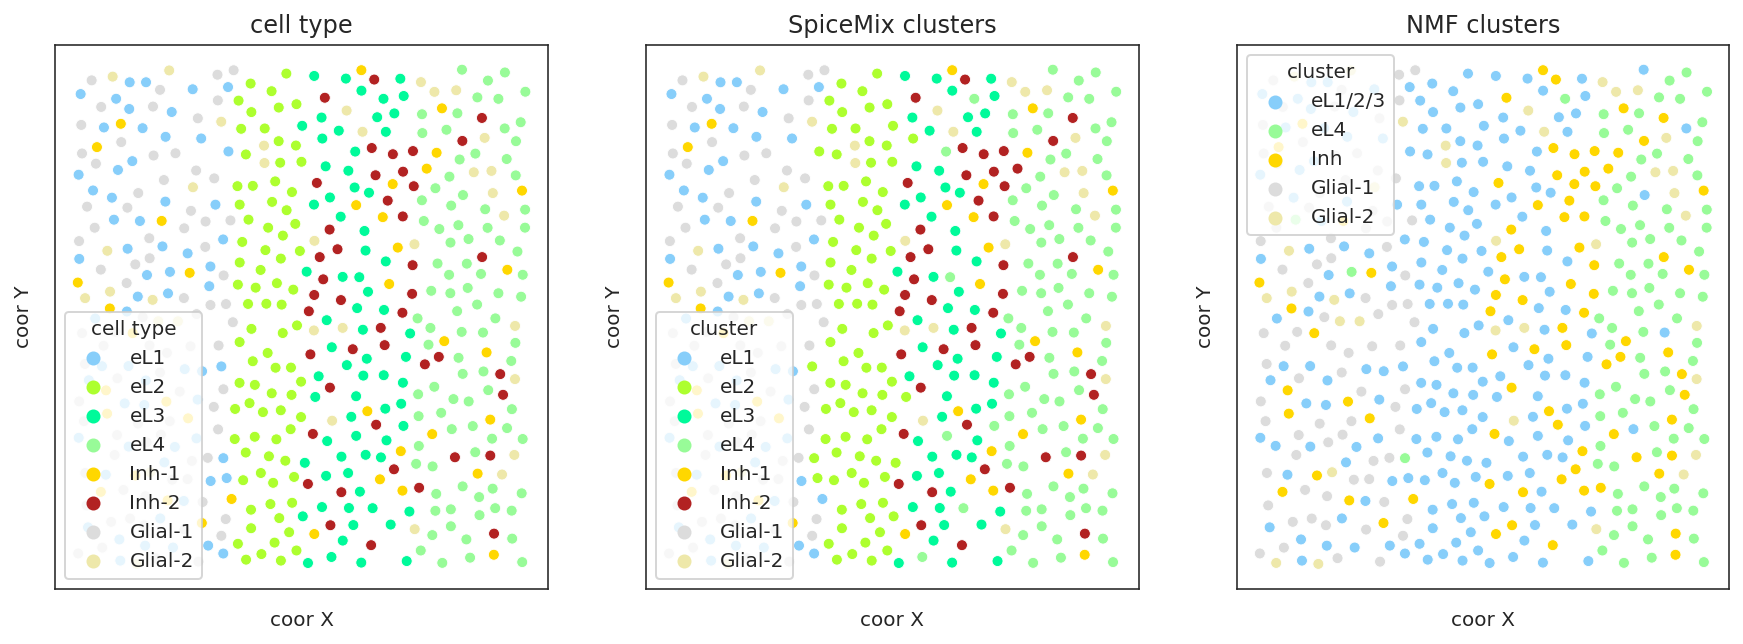

In [13]:
kwargs = dict(
    s=30,
    repli='0',
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
obj_SpiceMix.visualizeFeaturesSpace(
    axes[[0, 1]], ['cell type', 'cluster'], key_x='coor X', key_y='coor Y', **kwargs,
)
obj_NMF.visualizeFeatureSpace(axes[2], 'cluster'  , key_x='coor X', key_y='coor Y', **kwargs)
axes[1].set_title('SpiceMix clusters')
axes[2].set_title('NMF clusters')

We overlay the expression levels of a few selected genes on the spatial space.

A string 'expr ' (including the space) needs to be prepended to gene ID when passed to the visualization function.

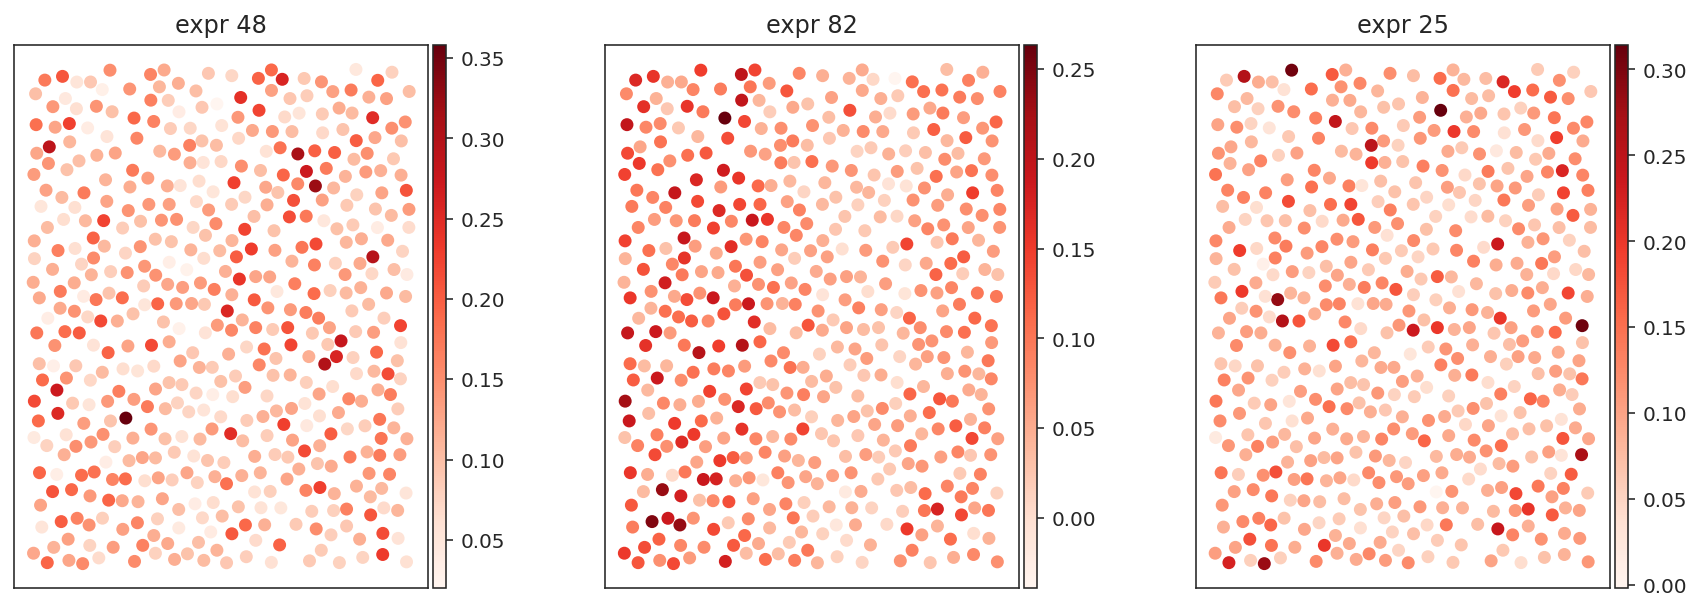

In [14]:
kwargs = dict(
    s=30, # change dot size here
    cmap=plt.get_cmap('Reds'),
    repli=0,
)

idx = [48, 82, 25]
idx = [f'expr {i}' for i in idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
obj_SpiceMix.visualizeFeaturesSpace(
    axes, idx, key_x='coor X', key_y='coor Y', **kwargs,
)

## Affinities
The local spatial patterns of SpiceMix clusters and metagenes can be quantified using affinity matrices.

We first visualize the affinity matrix estimated by SpiceMix.
Metagenes that exhibit layer-like patterns usually are attractive to themselves, reflected as positive affinities in the affinity matrix. In contrast, scattered metagenes are repellent to themselves, showing negative affinities.
Simiarly, a pair of metagenes that tend to express in neighboring cells are attractive to each other (ex. metagenes 0 and 8). And metagenes that are repellent to each others show negative affinities (ex. metagenes 7 and 8.

Iteration 500


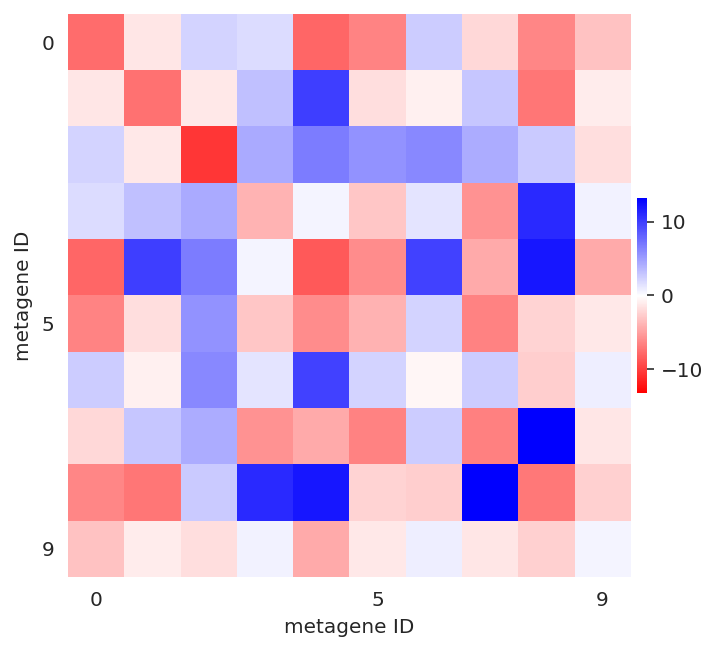

In [15]:
segmentdata = copy.deepcopy(plt.get_cmap('bwr')._segmentdata)
for key in ['red', 'green', 'blue']:
    segmentdata[key] = [(1.-i, k, j) for (i, j, k) in segmentdata[key][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)

fig, ax = plt.subplots(figsize=(6, 6))
obj_SpiceMix.visualizeAffinityMetagenes(ax, iiter=-1, **kwargs)

After we define clusters, we can find affinities between clusters.
Similar to metagenes, SpiceMix clusters can be attractive, repellent, and indifferent to any others.
A strong positive affinity between two cell types indicates the co-occurrence of them. For example, Glial-1 cells are localized in layer 1, and therefore are usually neighbors of eL1 neurons, consistent with the positive affiniy between Glial-1 and eL1.
A cluster that has a near-zero affinity to any other cluster, like Inh-1 and Glial-2, usually spreads everywhere and does not exhibit preference to neighboring any clusters.

Text(0.5, 0, 'NMF clusters')

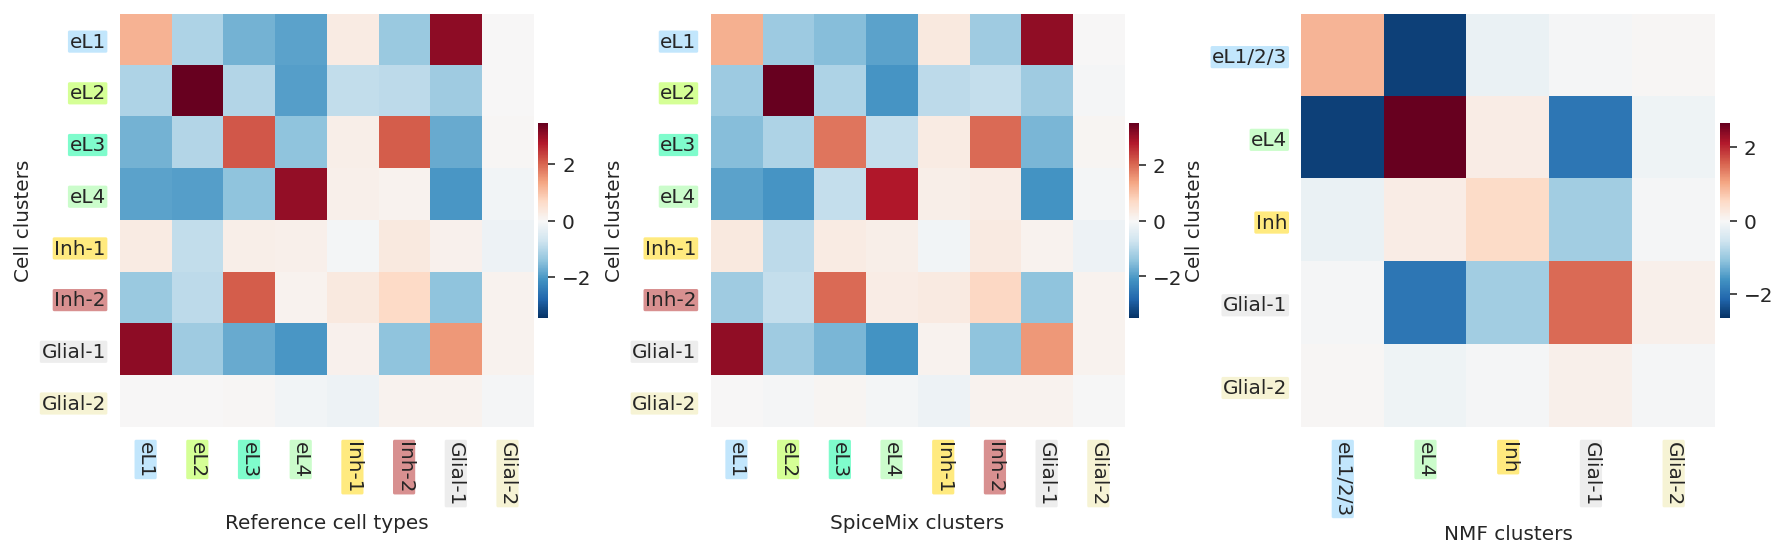

In [16]:
segmentdata = copy.deepcopy(plt.get_cmap('RdBu')._segmentdata)
for channel in ['red', 'green', 'blue']:
    segmentdata[channel] = [(1.-i, k, j) for (i, j, k) in segmentdata[channel][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
obj_NMF     .visualizeAffinityClusters(axes[0], ignores={'NA'}, **kwargs, key='cell type')
obj_SpiceMix.visualizeAffinityClusters(axes[1], ignores={'NA'}, **kwargs, key='cluster')
obj_NMF     .visualizeAffinityClusters(axes[2], ignores={'NA'}, **kwargs)
axes[0].set_xlabel('Reference cell types')
axes[0].set_xlabel('Reference cell types')
axes[1].set_xlabel('SpiceMix clusters')
axes[1].set_xlabel('SpiceMix clusters')
axes[2].set_xlabel('NMF clusters')
axes[2].set_xlabel('NMF clusters')

## Label comparison

We visualize the correlation between SpiceMix/NMF cluster and the reference cell type loaded from `celltypes_<FOV>.txt` via confusion matrix using function  `visualizeLabelEnrichment`.

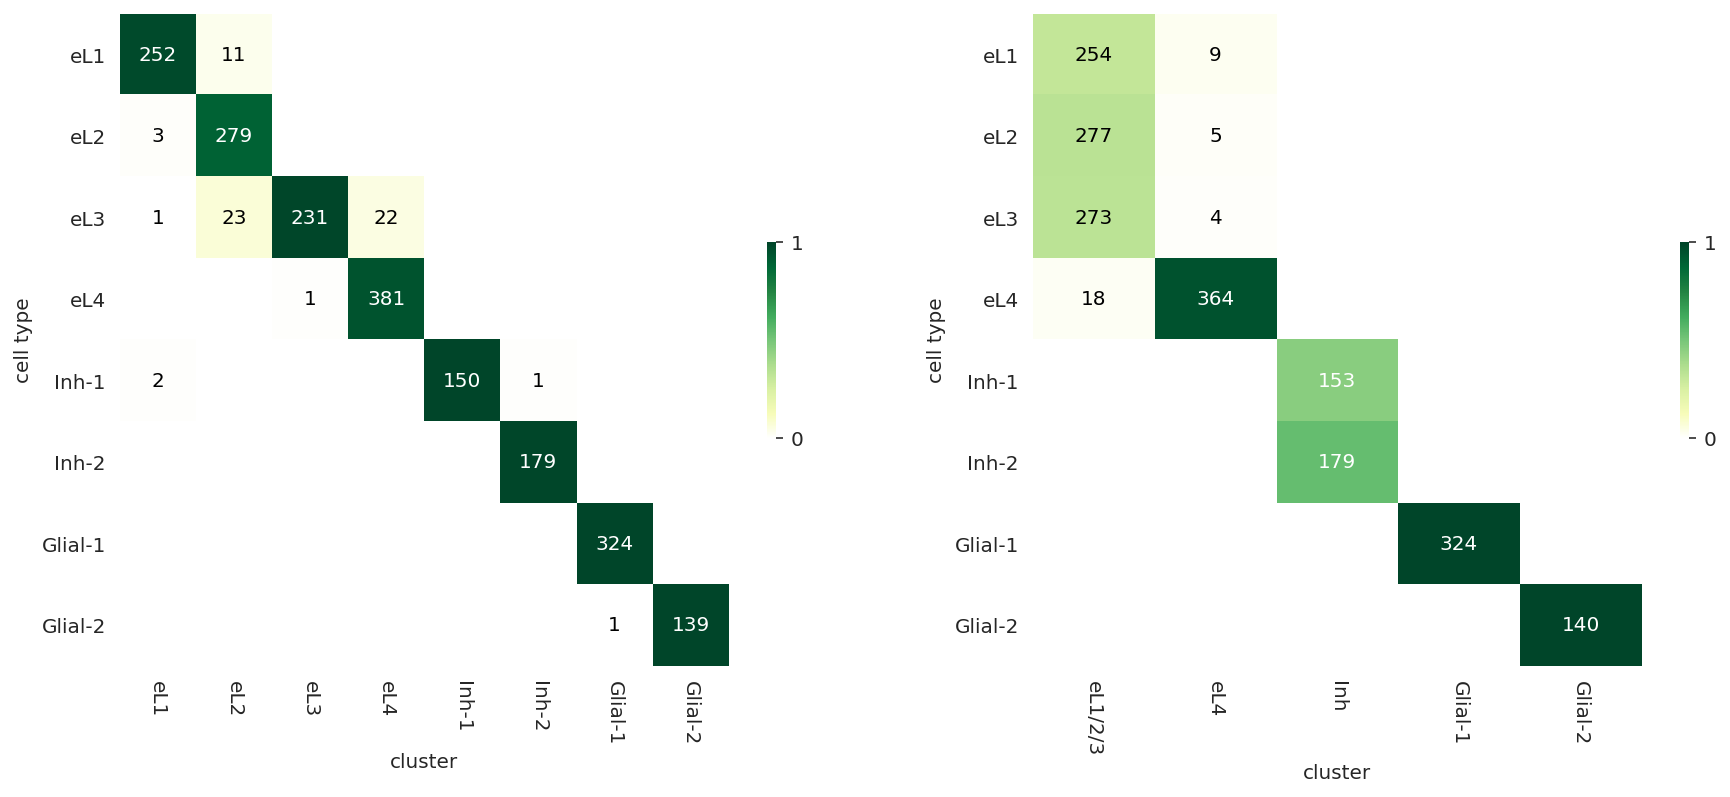

In [17]:
segmentdata = copy.deepcopy(plt.get_cmap('YlGn')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeLabelEnrichment(axes[0], **kwargs, ignores_x={'NA'})
obj_NMF     .visualizeLabelEnrichment(axes[1], **kwargs)

Using the same function, we can visualize the distribution of SpiceMix clusters in all 4 replicates/FOVs.

In this synthetic dataset, the four replicates are generated as technical replicates, so the cluster compositions in these replicates are expected to be similar.

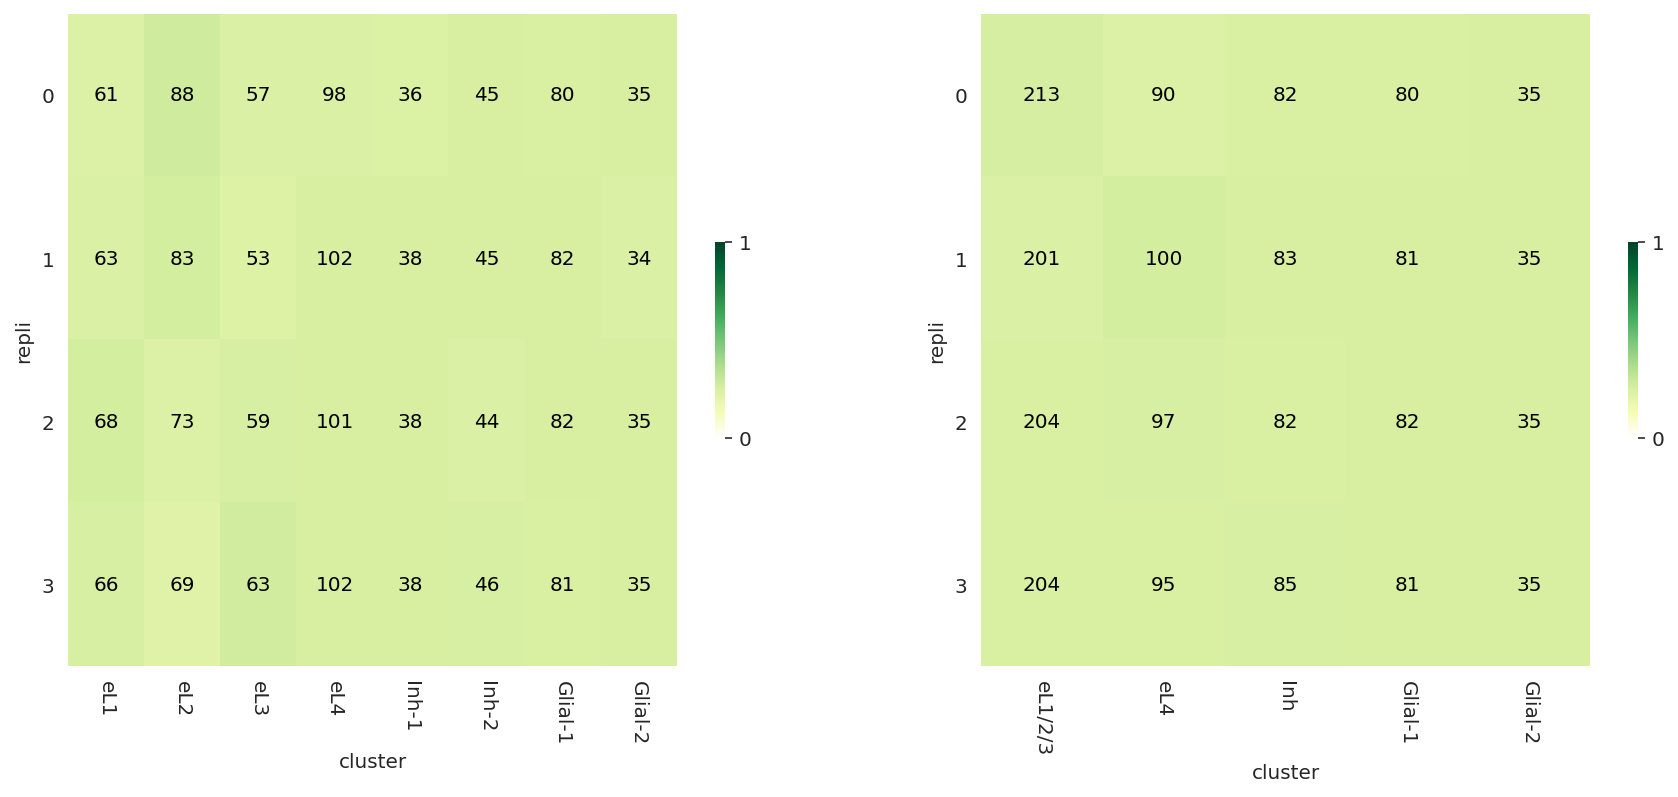

In [18]:
segmentdata = copy.deepcopy(plt.get_cmap('YlGn')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)

# the distribution of SpiceMix/NMF clusters in different replicates
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeLabelEnrichment(axes[0], **kwargs, key_x='cluster', key_y='repli', ignores_x={'NA'})
obj_NMF     .visualizeLabelEnrichment(axes[1], **kwargs, key_x='cluster', key_y='repli')

## Gene and metagene enrichment

By visualizing the metagene expressions in each SpiceMix cluster, we can identify metagenes that are 
- specific to major types: metagene 0 in excitatory neurons, and metagene 5 in inhibitory neurons
- specific to subtypes: metagenes 1\~3 in eL1\~3, metagenes 6 and 7 in Inh-1 and Inh-2, respectively
- specific to a layer (a spatial region): metagene 8 in layer 1, because metagene 8 is enriched in eL1 and Glial-1 that are localized in layer 1.

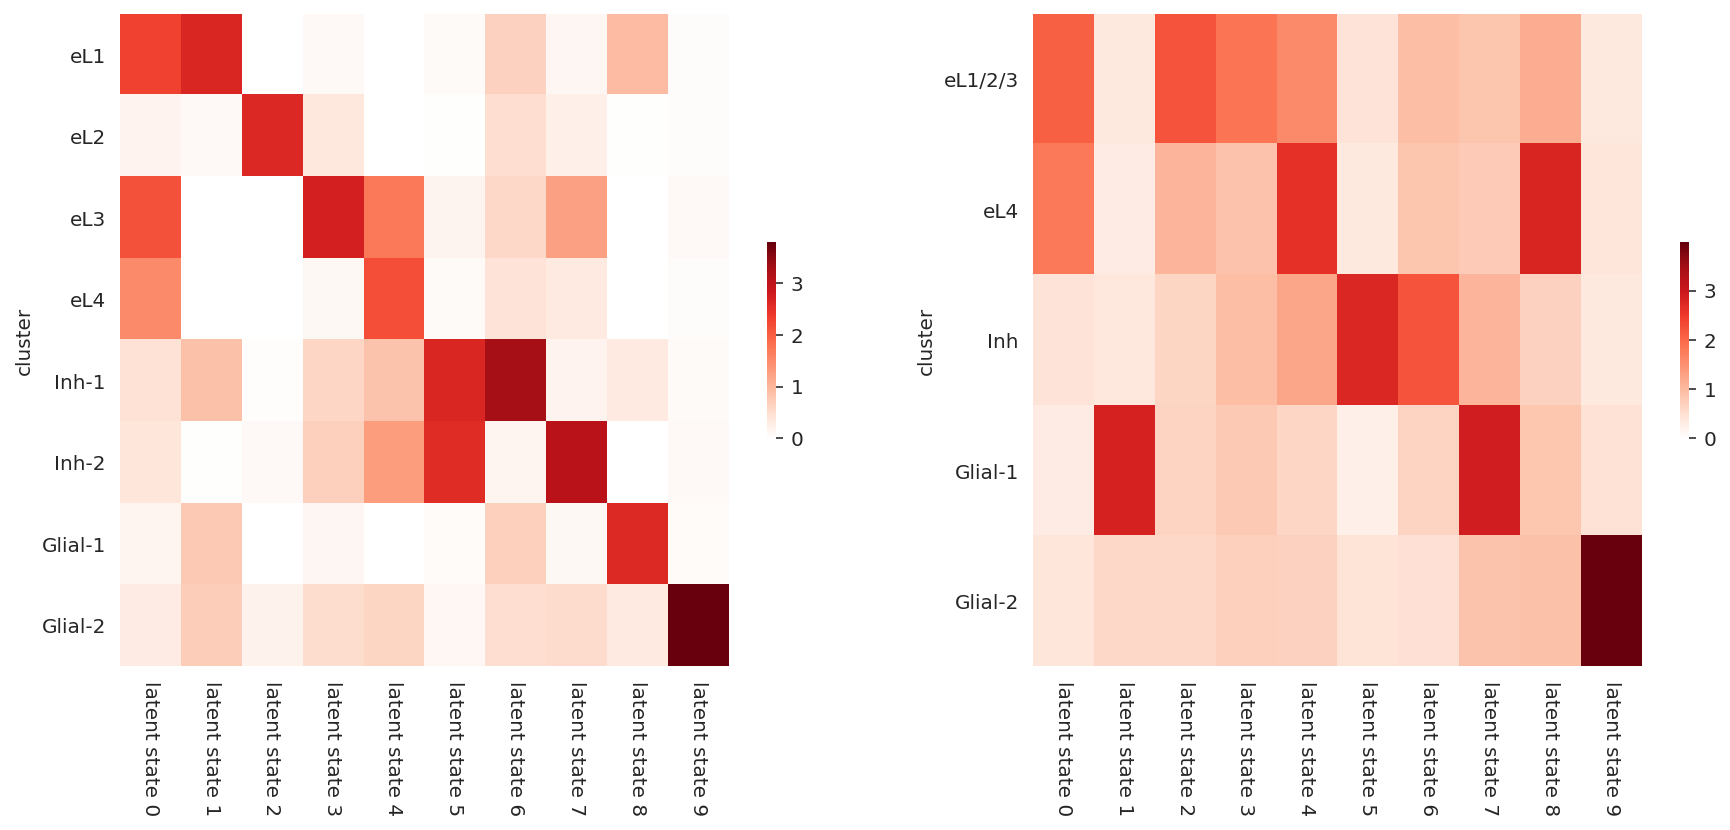

In [19]:
segmentdata = copy.deepcopy(plt.get_cmap('Reds')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs=dict(
    cmap=cm,
)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeFeatureEnrichment(
    axes[0], **kwargs, ignores_y=['NA'],
    normalizer_raw=StandardScaler(with_mean=False).fit_transform,
)
obj_NMF     .visualizeFeatureEnrichment(
    axes[1], **kwargs,
    keys_x=obj_NMF.columns_latent_states,
    normalizer_raw=StandardScaler(with_mean=False).fit_transform,
)

We can also validate SpiceMix clusters using the expression levels of marker genes in the clusters.

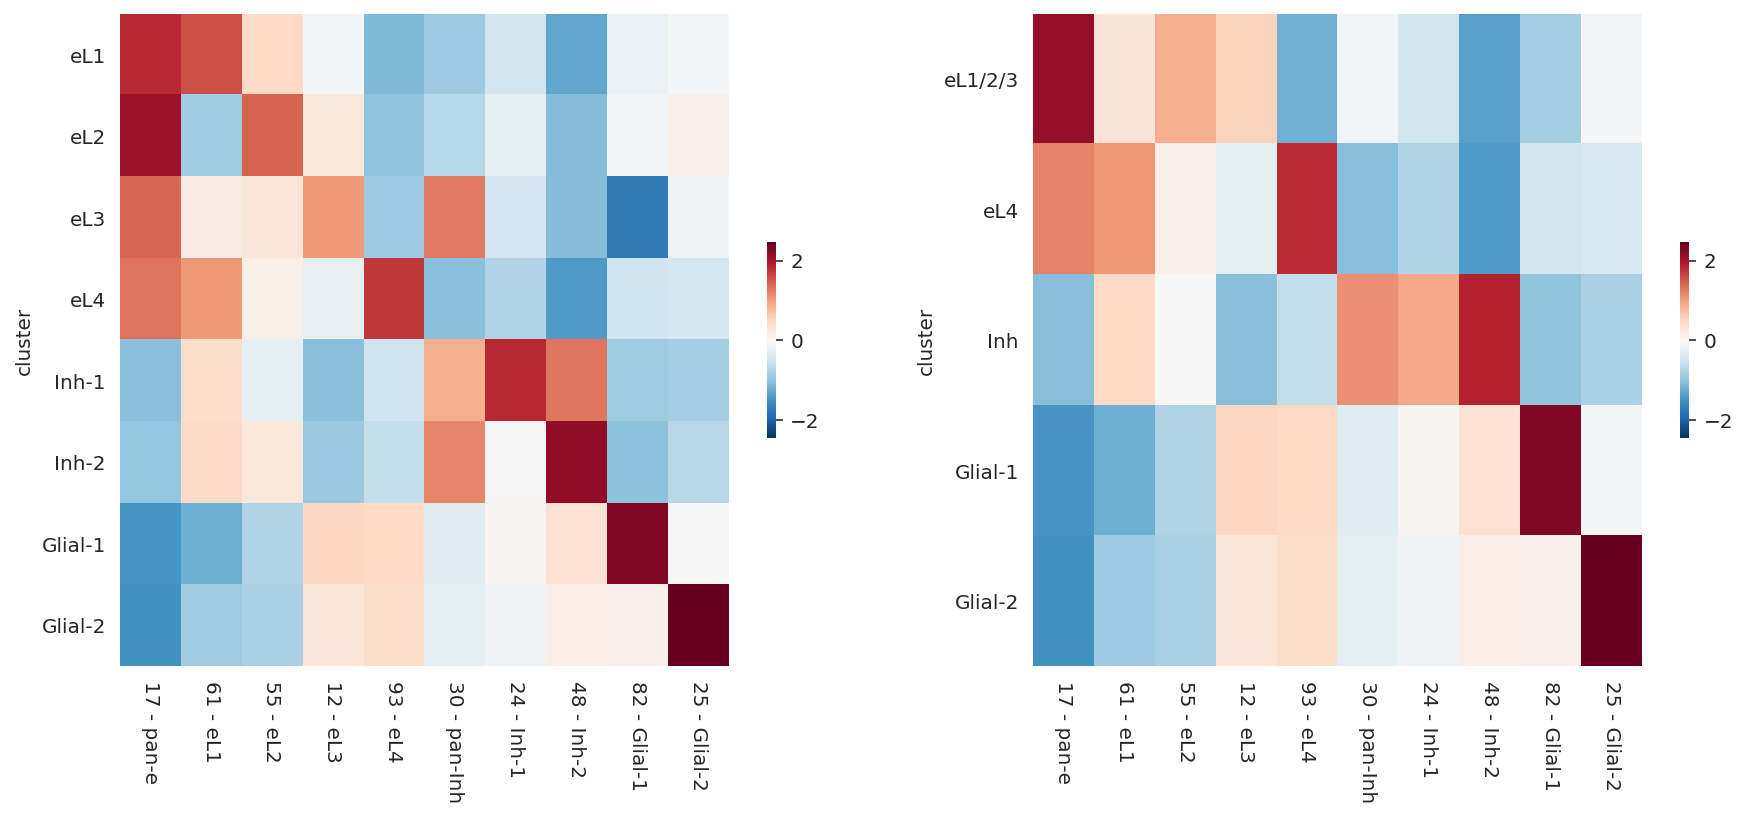

In [20]:
segmentdata = copy.deepcopy(plt.get_cmap('RdBu')._segmentdata)
for key in ['red', 'green', 'blue']:
    segmentdata[key] = [(1.-i, k, j) for (i, j, k) in segmentdata[key][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs=dict(
    cmap=cm,
)

# In the first column are the gene IDs, and in the second column are annotations, 
# In this example, the annotation is the major type or subtype of the marker gene
gene_list_plot = np.array([
    ('17',	'pan-e'),
    ('61',	'eL1'),
    ('55',	'eL2'),
    ('12',	'eL3'),
    ('93',	'eL4'),
    
    ('30',	'pan-Inh'),
    ('24',	'Inh-1'),
    ('48',	'Inh-2'),
    
    ('82',	'Glial-1'),
    ('25',	'Glial-2'),
])
# Extract gene IDs and prepend string 'expr '
keys_x = [f'expr {_[0]}' for _ in gene_list_plot]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeFeatureEnrichment(
    axes[0], keys_x=keys_x, **kwargs, ignores_y=['NA'],
    normalizer_raw=StandardScaler().fit_transform,
    normalizer_avg=lambda x: StandardScaler().fit_transform(x.T).T,
)
obj_NMF     .visualizeFeatureEnrichment(
    axes[1], keys_x=keys_x, **kwargs,
    normalizer_raw=StandardScaler().fit_transform,
    normalizer_avg=lambda x: StandardScaler().fit_transform(x.T).T,
)
for ax in axes:
    ax.set_xticklabels(' - '.join(_) for _ in gene_list_plot)